## 0 - Pull in dependencies and initiate Duet sessions

In [1]:
# First lets pull in our dependencies and initiate our duet session
import torch
import random
from torch import nn
from torch import optim
import syft as sy

## 0.1 - initiate Duet session 1 and check data split

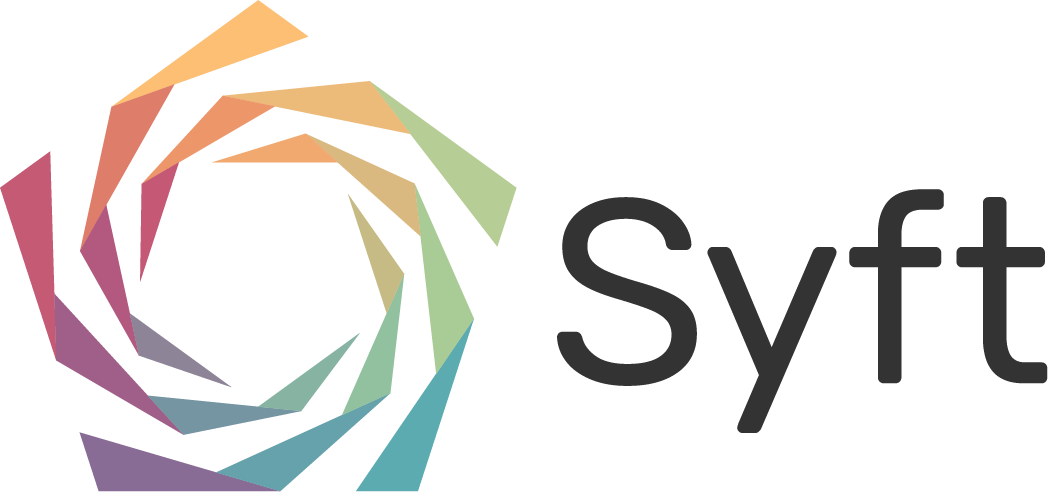

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [2]:
duet1 = sy.join_duet(loopback=True)

In [4]:
duet1.store.pandas

ID       Tags Description  \
0  <UID: dd424140bd434d8cb485d9944fbf6b54>  [dataset]     Split 1   

              object_type  
0  <class 'torch.Tensor'>

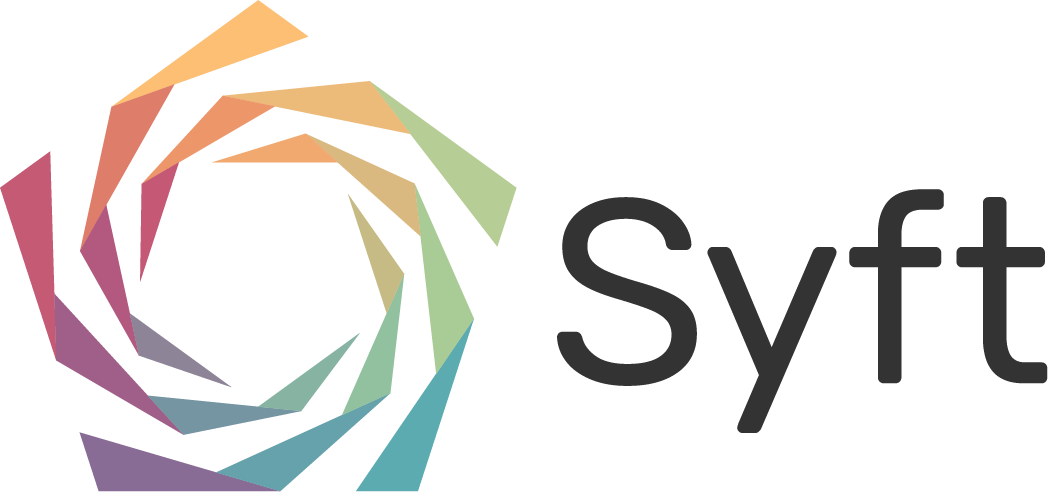

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [5]:
duet2 = sy.join_duet(loopback=True)

In [7]:
duet2.store.pandas

ID       Tags Description  \
0  <UID: 4de8747ebddd4ddf822b3623a5eb3115>  [dataset]     Split 2   

              object_type  
0  <class 'torch.Tensor'>

## 1 - Define and send our remote assets

Here we'll define the remote model which will have the remote input data fed into it. This includes;

- Our first model segment
- Our dummy input data

In [13]:
remote_torch1 = duet1.torch
remote_torch2 = duet2.torch

# In order to serialise our model we need to define it as below
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.lin = self.torch_ref.nn.Linear(1,1)

    def forward(self, x):
        x = self.lin(x)
        return x

#Model 1
model1 = SyNet(torch)
model1_ptr = model1.send(duet1)
opt1 = remote_torch1.optim.SGD(params=model1_ptr.parameters(),lr=0.1)

data1_pointer = duet1.store[0]

#Model 2
model2 = SyNet(torch)
model2_ptr = model2.send(duet2)
opt2 = remote_torch2.optim.SGD(params=model2_ptr.parameters(),lr=0.1)

data2_pointer = duet2.store[0]

## 2 - Define and send our local assets

Here we'll define the remote model which will have the remote input data fed into it. This includes;

- Our second model segment
- Our dummy labels

In [14]:
model3 = nn.Linear(2,1)
opt3 = optim.SGD(params=model3.parameters(),lr=0.1)

target= torch.tensor([[0],[0],[1],[1.]])

## 3 - Define our training logic

In [15]:
for iter in range(20):
    opt1.zero_grad()
    opt2.zero_grad()
    opt3.zero_grad()


    activation1_ptr = model1_ptr(data1_pointer)
    activation1_ptr.request(reason="process the model", timeout_secs = -1)
    activation1 = activation1_ptr.clone().get()

    activation2_ptr = model2_ptr(data2_pointer)
    activation2_ptr.request(reason="process the model", timeout_secs = -1)
    activation2 = activation2_ptr.clone().get()

    activation = torch.cat((activation1, activation2), 1)
    pred = model3(activation)
    loss = ((pred - target)**2).sum()
    loss.backward()


    grad1_ptr = activation1.grad.clone().send(duet1)
    grad2_ptr = activation2.grad.clone().send(duet2)

    activation1_ptr.backward(grad1_ptr)
    activation2_ptr.backward(grad2_ptr)


    opt1.step()
    opt2.step()
    opt3.step()


    print(loss)

tensor(1.0545, grad_fn=<SumBackward0>)
tensor(0.8202, grad_fn=<SumBackward0>)
tensor(0.6490, grad_fn=<SumBackward0>)
tensor(0.5278, grad_fn=<SumBackward0>)
tensor(0.4128, grad_fn=<SumBackward0>)
tensor(0.3055, grad_fn=<SumBackward0>)
tensor(0.2128, grad_fn=<SumBackward0>)
tensor(0.1387, grad_fn=<SumBackward0>)
tensor(0.0851, grad_fn=<SumBackward0>)
tensor(0.0494, grad_fn=<SumBackward0>)
tensor(0.0276, grad_fn=<SumBackward0>)
tensor(0.0153, grad_fn=<SumBackward0>)
tensor(0.0089, grad_fn=<SumBackward0>)
tensor(0.0059, grad_fn=<SumBackward0>)
tensor(0.0050, grad_fn=<SumBackward0>)
tensor(0.0056, grad_fn=<SumBackward0>)
tensor(0.0074, grad_fn=<SumBackward0>)
tensor(0.0113, grad_fn=<SumBackward0>)
tensor(0.0171, grad_fn=<SumBackward0>)
tensor(0.0283, grad_fn=<SumBackward0>)
